In [1]:
#importing required modules
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
!pip install mlxtend
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.cluster import KMeans


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\visions\utils\monkeypatches\imghdr_patch.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  from imghdr import tests
C:\Users\Matty\AppData\Local\Temp\ipykernel_14096\2379114084.py:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
#read data from csv file 
df=pd.read_csv("./Report Data.csv")


In [3]:
#display raw data
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
#initial exploration of data
ProfileReport(df)

c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\profile_report.py:482: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\report\presentation\flavours\widget\correlation_table.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\report\presentation\flavours\widget\duplicate.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packag

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
#https://stackoverflow.com/questions/45386955/python-replacing-outliers-values-with-median-values
#removing outlier where heartrate is unreasonably low
mean = df['HeartRate'].mean()
df["HeartRate"] = np.where(df["HeartRate"] <10, mean,df['HeartRate'])

In [6]:
#304 duplicate rows dropped (30%)
#df = df.drop_duplicates()
#one hot encoding of risk level data
encoder=ce.OneHotEncoder(cols='RiskLevel',handle_unknown='ignore',return_df=True,use_cat_names=True)
risk_encoded = encoder.fit_transform(df[['RiskLevel']])
df = df.join(risk_encoded)
df = df.fillna(0)


In [7]:
#display new data
df.head()

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
0   25         130           80  15.0      98.0       86.0  high risk   
1   35         140           90  13.0      98.0       70.0  high risk   
2   29          90           70   8.0     100.0       80.0  high risk   
3   30         140           85   7.0      98.0       70.0  high risk   
4   35         120           60   6.1      98.0       76.0   low risk   

   RiskLevel_high risk  RiskLevel_low risk  RiskLevel_mid risk  
0                    1                   0                   0  
1                    1                   0                   0  
2                    1                   0                   0  
3                    1                   0                   0  
4                    0                   1                   0

#### Linear regression

In [8]:
#droping variables not useful for regression  
x = df.drop(['BS', 'HeartRate','SystolicBP','RiskLevel'], axis=1)
y=df['SystolicBP']
x

Age  DiastolicBP  BodyTemp  RiskLevel_high risk  RiskLevel_low risk  \
0      25           80      98.0                    1                   0   
1      35           90      98.0                    1                   0   
2      29           70     100.0                    1                   0   
3      30           85      98.0                    1                   0   
4      35           60      98.0                    0                   1   
...   ...          ...       ...                  ...                 ...   
1009   22           60      98.0                    1                   0   
1010   55           90      98.0                    1                   0   
1011   35           60      98.0                    1                   0   
1012   43           90      98.0                    1                   0   
1013   32           65     101.0                    0                   0   

      RiskLevel_mid risk  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
...                  ...  
1009                   0  
1010                   0  
1011                   0  
1012                   0  
1013                   1  

[1014 rows x 6 columns]

In [9]:
#performing train test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=2)

In [10]:
#setting linear regression as the model
model = LinearRegression()

In [11]:
#fitting the training data to the model 
model.fit(X_train,y_train)

LinearRegression()

In [12]:
#predicting on the test data 
predictions = model.predict(X_test)

In [13]:
#printing error metrics
print(
  'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
  'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  103.20717965699818
mean_absolute_error :  8.078438977387172


In [14]:
#finding the r2 value of the predictions
from sklearn.metrics import r2_score
r2_score(y_test,predictions)

0.7087778973600987

### PCA

In [15]:
#doing principal componant analysis
#setting features for pca 
features = ['Age', 'DiastolicBP', 'BodyTemp', 'RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_mid risk']
#setting x and y for PCA
pcax = df.loc[:, features].values
pcay = df.loc[:,['SystolicBP']].values
#scaling the x data for PCA
pcax = StandardScaler().fit_transform(pcax)
#printing to confirm data is transformed
print(pcax)
print(pcay)

[[-0.36173812  0.25502279 -0.4852155   1.65164802 -0.81716777 -0.70397104]
 [ 0.38077697  0.97553854 -0.4852155   1.65164802 -0.81716777 -0.70397104]
 [-0.06473208 -0.46549297  0.97388449  1.65164802 -0.81716777 -0.70397104]
 ...
 [ 0.38077697 -1.18600873 -0.4852155   1.65164802 -0.81716777 -0.70397104]
 [ 0.97478904  0.97553854 -0.4852155   1.65164802 -0.81716777 -0.70397104]
 [ 0.15802244 -0.82575085  1.70343448 -0.60545588 -0.81716777  1.42051299]]
[[130]
 [140]
 [ 90]
 ...
 [ 85]
 [120]
 [120]]


In [16]:
#setting three principal components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(pcax)
New_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
#putting the 3 new components into new df
New_df

PC1       PC2       PC3
0     1.348363 -0.112282  0.892404
1     2.085714 -0.268259  0.529739
2     0.900063  0.449758  1.899882
3     1.717039 -0.190270  0.711071
4    -1.092592 -1.340167 -0.205387
...        ...       ...       ...
1009  0.477479  0.060608  1.244590
1010  2.796087 -0.431863  0.090747
1011  0.939221 -0.045735  0.959245
1012  2.369863 -0.333700  0.354142
1013 -0.807673  2.144147  0.310065

[1014 rows x 3 columns]

In [17]:
Final_df = pd.concat([New_df, y], axis=1)
#adding systolic bp to the pca data and printing 
Final_df.head()

PC1       PC2       PC3  SystolicBP
0  1.348363 -0.112282  0.892404         130
1  2.085714 -0.268259  0.529739         140
2  0.900063  0.449758  1.899882          90
3  1.717039 -0.190270  0.711071         140
4 -1.092592 -1.340167 -0.205387         120

In [18]:
pca_results = pca.explained_variance_ratio_

In [19]:
print(pca_results[0] + pca_results[1] + pca_results[2])
#printing the combined variance ratio of the 3 componants a

0.810481046828306


### Age heart rate analysis 

In [20]:
df['Age_Range'] = pd.cut(x=df['Age'], bins=[9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, np.inf], 
                         labels = ['9-15', '16-21', '22-27', '28-33', '34-39', '40-45', '46-51','52-57','58-63','64-69', '70+'])
#splitting age into bins

In [21]:
df['Age_Range'].unique()
#confirming bins are correct 

['22-27', '34-39', '28-33', '40-45', '16-21', ..., '9-15', '58-63', '52-57', '64-69', '70+']
Length: 11
Categories (11, object): ['9-15' < '16-21' < '22-27' < '28-33' ... '52-57' < '58-63' < '64-69' < '70+']

In [22]:
print(df['Age_Range'].value_counts(normalize = True)*100)
print(df['Age'].mean())
#https://stackoverflow.com/questions/30482071/how-to-calculate-mean-values-grouped-on-another-column-in-pandas
age_df = df.groupby('Age_Range', as_index=False)['HeartRate'].mean()
print(age_df)
print(df['Age'].corr(df['HeartRate']))
#printing some explanatory metrics for age 


16-21    22.189349
22-27    17.652860
28-33    17.061144
9-15     11.242604
46-51     7.889546
40-45     7.692308
34-39     7.001972
52-57     4.930966
58-63     3.846154
64-69     0.394477
70+       0.098619
Name: Age_Range, dtype: float64
29.871794871794872
   Age_Range  HeartRate
0       9-15  72.508772
1      16-21  73.393794
2      22-27  74.396648
3      28-33  76.381503
4      34-39  74.126761
5      40-45  73.987179
6      46-51  78.825000
7      52-57  72.300000
8      58-63  72.384615
9      64-69  79.500000
10       70+  70.000000
0.06769164318150733


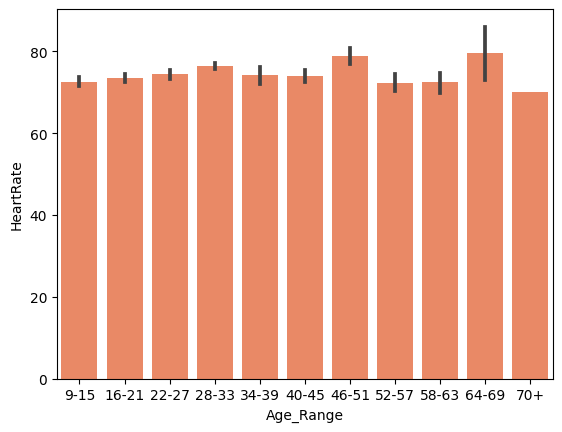

In [23]:
sns.barplot(x = df['Age_Range'],y=df['HeartRate'], data =df, color = 'coral')
plt.savefig('Age range, heart rate split')
#visualising age and heart rate

16-21    22.189349
22-27    17.652860
28-33    17.061144
9-15     11.242604
46-51     7.889546
40-45     7.692308
34-39     7.001972
52-57     4.930966
58-63     3.846154
64-69     0.394477
70+       0.098619
Name: Age_Range, dtype: float64


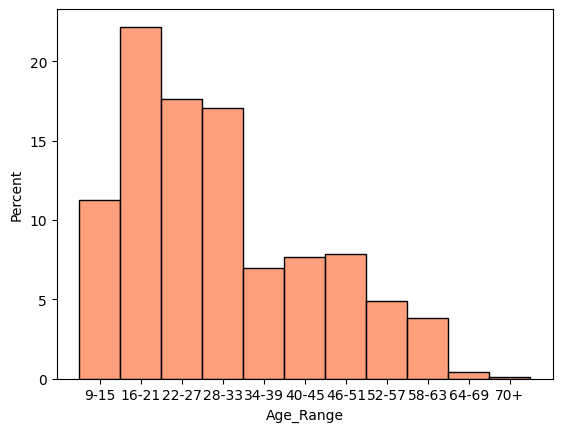

In [24]:
print(df['Age_Range'].value_counts(normalize = True)*100)
sns.histplot(x = df['Age_Range'], data =df, stat = 'percent', color = 'coral')
plt.savefig('Age range split')
#visualising ranges as a proportion of data

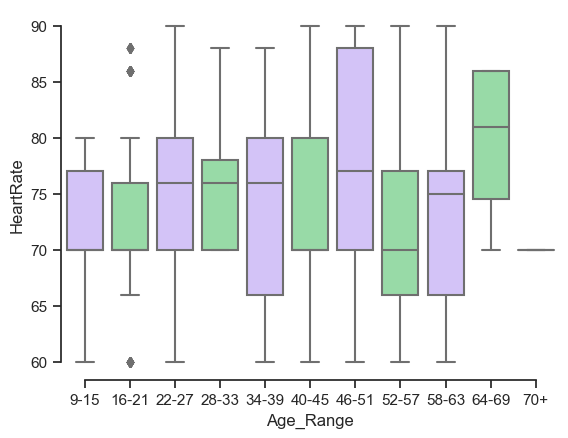

In [25]:
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="Age_Range", y="HeartRate", palette=["m", "g"],
            data=df)
sns.despine(offset=1, trim=True)
plt.savefig('heart rate age range')
plt.show()
#showing mean heart rate/age as a box plot

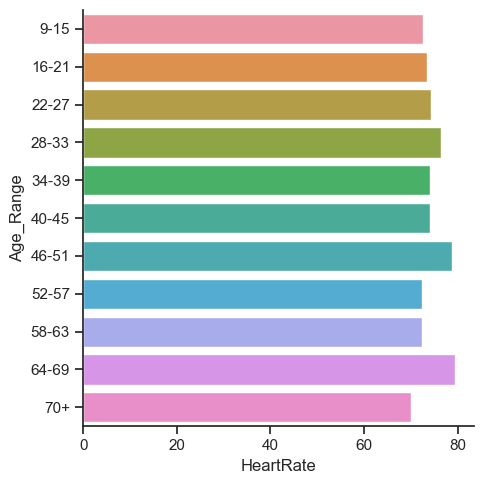

In [26]:
sns.catplot(data = age_df, kind = 'bar', x = 'HeartRate', y = 'Age_Range')
plt.savefig('heart rate age range bar')
#bar plot of age bins and heart rate

### Association

In [27]:
df['SystolicBP_rating'] = pd.cut(x=df['SystolicBP'], bins=[0, 109, 139 ,np.inf], 
                         labels = ['low' ,'normal', 'high'])
#splitting systolic BP into bins


In [28]:
df['DiastolicBP_rating'] = pd.cut(x=df['DiastolicBP'], bins=[0, 69, 89 ,np.inf], 
                         labels = ['low' ,'normal', 'high'])
#spliting diastolic BP into bins 

In [29]:
BPdf = df[['DiastolicBP_rating', 'SystolicBP_rating']]
print(BPdf['DiastolicBP_rating'].value_counts())
print(BPdf['SystolicBP_rating'].value_counts())
print(BPdf['DiastolicBP_rating'].unique())
print(BPdf['SystolicBP_rating'].unique())
#printing explanaroty metrics for both blood pressures 

normal    417
low       321
high      276
Name: DiastolicBP_rating, dtype: int64
normal    540
low       344
high      130
Name: SystolicBP_rating, dtype: int64
['normal', 'high', 'low']
Categories (3, object): ['low' < 'normal' < 'high']
['normal', 'high', 'low']
Categories (3, object): ['low' < 'normal' < 'high']


In [30]:
encoder=ce.OneHotEncoder(cols=BPdf.columns ,handle_unknown='ignore',return_df=True,use_cat_names=True)
BP_encoded = encoder.fit_transform(BPdf)
#one hot encoding blood pressuress

In [31]:
BP_encoded

DiastolicBP_rating_low  DiastolicBP_rating_normal  \
0                          0                          1   
1                          0                          0   
2                          0                          1   
3                          0                          1   
4                          1                          0   
...                      ...                        ...   
1009                       1                          0   
1010                       0                          0   
1011                       1                          0   
1012                       0                          0   
1013                       1                          0   

      DiastolicBP_rating_high  SystolicBP_rating_low  \
0                           0                      0   
1                           1                      0   
2                           0                      1   
3                           0                      0   
4                           0                      0   
...                       ...                    ...   
1009                        0                      0   
1010                        1                      0   
1011                        0                      1   
1012                        1                      0   
1013                        0                      0   

      SystolicBP_rating_normal  SystolicBP_rating_high  
0                            1                       0  
1                            0                       1  
2                            0                       0  
3                            0                       1  
4                            1                       0  
...                        ...                     ...  
1009                         1                       0  
1010                         1                       0  
1011                         0                       0  
1012                         1                       0  
1013                         1                       0  

[1014 rows x 6 columns]

In [32]:
BP_resutls = apriori(BP_encoded, min_support = 0.001, use_colnames = True, verbose = 1)
BP_resutls
#applying apriori to find support

Processing 27 combinations | Sampling itemset size 3


c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


support                                           itemsets
0   0.316568                           (DiastolicBP_rating_low)
1   0.411243                        (DiastolicBP_rating_normal)
2   0.272189                          (DiastolicBP_rating_high)
3   0.339250                            (SystolicBP_rating_low)
4   0.532544                         (SystolicBP_rating_normal)
5   0.128205                           (SystolicBP_rating_high)
6   0.266272    (SystolicBP_rating_low, DiastolicBP_rating_low)
7   0.050296  (SystolicBP_rating_normal, DiastolicBP_rating_...
8   0.063116  (DiastolicBP_rating_normal, SystolicBP_rating_...
9   0.335306  (DiastolicBP_rating_normal, SystolicBP_rating_...
10  0.012821  (DiastolicBP_rating_normal, SystolicBP_rating_...
11  0.009862   (DiastolicBP_rating_high, SystolicBP_rating_low)
12  0.146943  (DiastolicBP_rating_high, SystolicBP_rating_no...
13  0.115385  (DiastolicBP_rating_high, SystolicBP_rating_high)

In [33]:
bp_conf = association_rules(BP_resutls)
bp_conf
#printing association rules

antecedents                 consequents  \
0     (DiastolicBP_rating_low)     (SystolicBP_rating_low)   
1  (DiastolicBP_rating_normal)  (SystolicBP_rating_normal)   
2     (SystolicBP_rating_high)   (DiastolicBP_rating_high)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.316568            0.339250  0.266272    0.841121  2.479352   
1            0.411243            0.532544  0.335306    0.815348  1.531042   
2            0.128205            0.272189  0.115385    0.900000  3.306522   

   leverage  conviction  zhangs_metric  
0  0.158876    4.158835       0.873048  
1  0.116301    2.531545       0.589122  
2  0.080489    7.278107       0.800151

In [34]:
print(df['SystolicBP_rating'].value_counts(normalize = True)*100)
print(df['DiastolicBP_rating'].value_counts(normalize = True)*100)
#printing composition of blood pressure data

normal    53.254438
low       33.925049
high      12.820513
Name: SystolicBP_rating, dtype: float64
normal    41.124260
low       31.656805
high      27.218935
Name: DiastolicBP_rating, dtype: float64


### Clustering 

In [35]:
syst_bp_df = df[['SystolicBP', 'Age', 'HeartRate']]
#setting clustering variables

In [36]:
#https://www.kaggle.com/code/fazilbtopal/popular-unsupervised-clustering-algorithms
kmeans = KMeans(n_clusters = 3)
#set number of clusters
syst_bp_df['Cluster'] = kmeans.fit_predict (syst_bp_df)
syst_bp_df['Cluster'] = syst_bp_df['Cluster'].astype("category")
#adding predicted clusters to the dataframe
syst_bp_df.head()

c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Matty\AppData\Local\Temp\ipykernel_14096\4277029544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syst_bp_df['Cluster'] = kmeans.fit_predict (syst_bp_df)
C:\Users\Matty\AppData\Local\Temp\ipykernel_14096\4277029544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

SystolicBP  Age  HeartRate Cluster
0         130   25       86.0       1
1         140   35       70.0       1
2          90   29       80.0       0
3         140   30       70.0       1
4         120   35       76.0       1

# Clustering visualisation

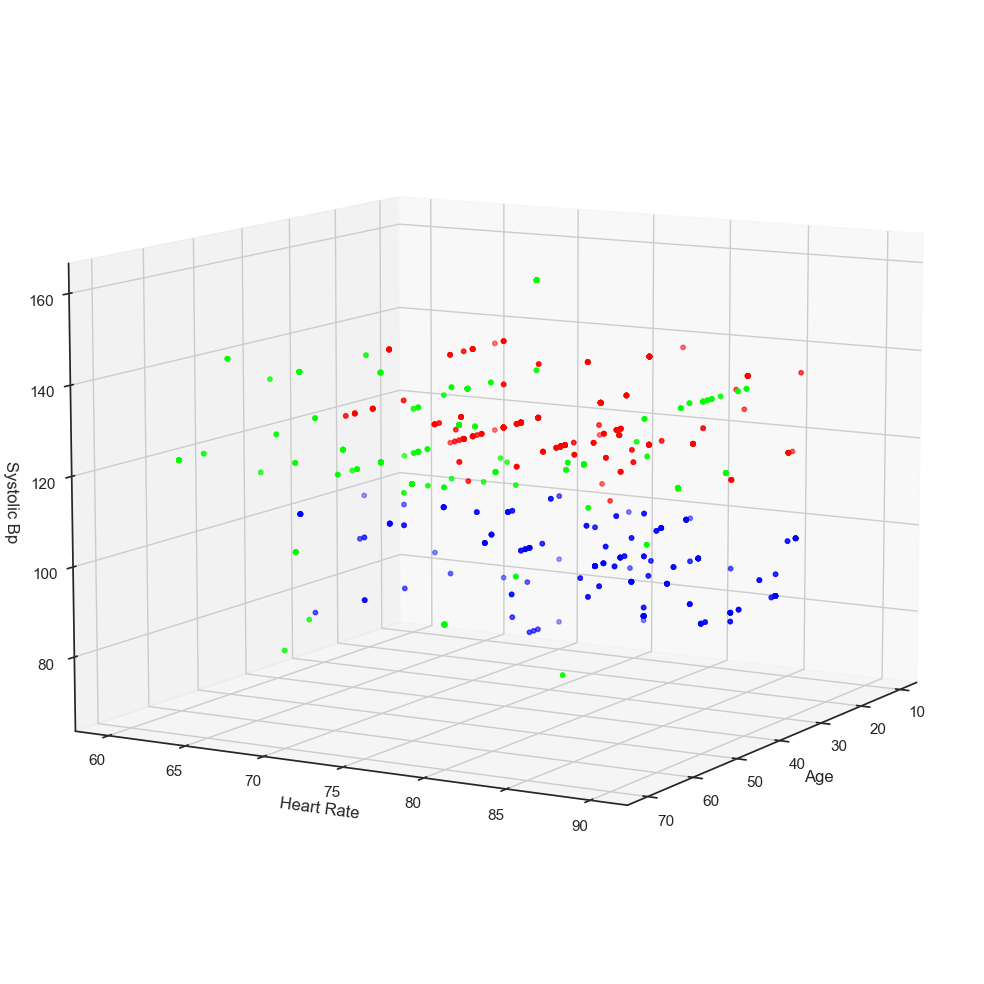

In [37]:
fig1=plt.figure(figsize=(10,10))
#set figure size
ax= plt.axes(projection = '3d')
#set projection as 3d to allow for the plotting of 3 variables
ax.set_xlabel('Age')
ax.set_ylabel('Heart Rate')
ax.set_zlabel('Systolic Bp')
#labling axis
plt.tight_layout()
#tight layout to prevent axis titles being out of the frame
ax.scatter(xs=syst_bp_df['Age'], ys = syst_bp_df['HeartRate'],zs=syst_bp_df['SystolicBP'], c=syst_bp_df['Cluster'],
 s = 10, cmap = 'brg')
#plotting data with the colour map brg
ax.view_init(10, 30)
#setting rotation of the frame to 10,30
plt.savefig('clustering_rotate 1')
#saving

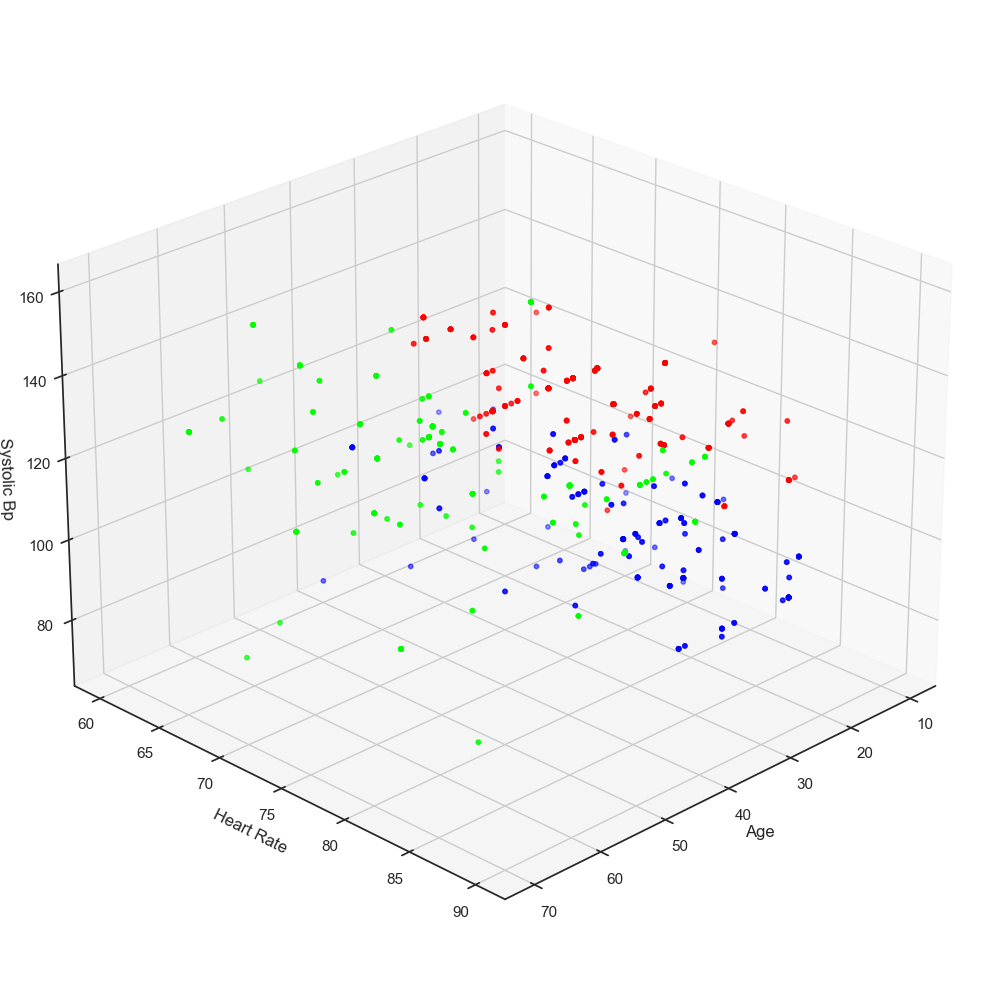

In [38]:
#as above but rotational view changed
fig2=plt.figure(figsize=(10,10))
ax= plt.axes(projection = '3d')
ax.set_xlabel('Age')
ax.set_ylabel('Heart Rate')
ax.set_zlabel('Systolic Bp')
plt.tight_layout()
ax.scatter(xs=syst_bp_df['Age'], ys = syst_bp_df['HeartRate'],zs=syst_bp_df['SystolicBP'], c=syst_bp_df['Cluster'],
 s = 10, cmap = 'brg')
ax.view_init(25, 45)

plt.savefig('clustering_rotate 2')

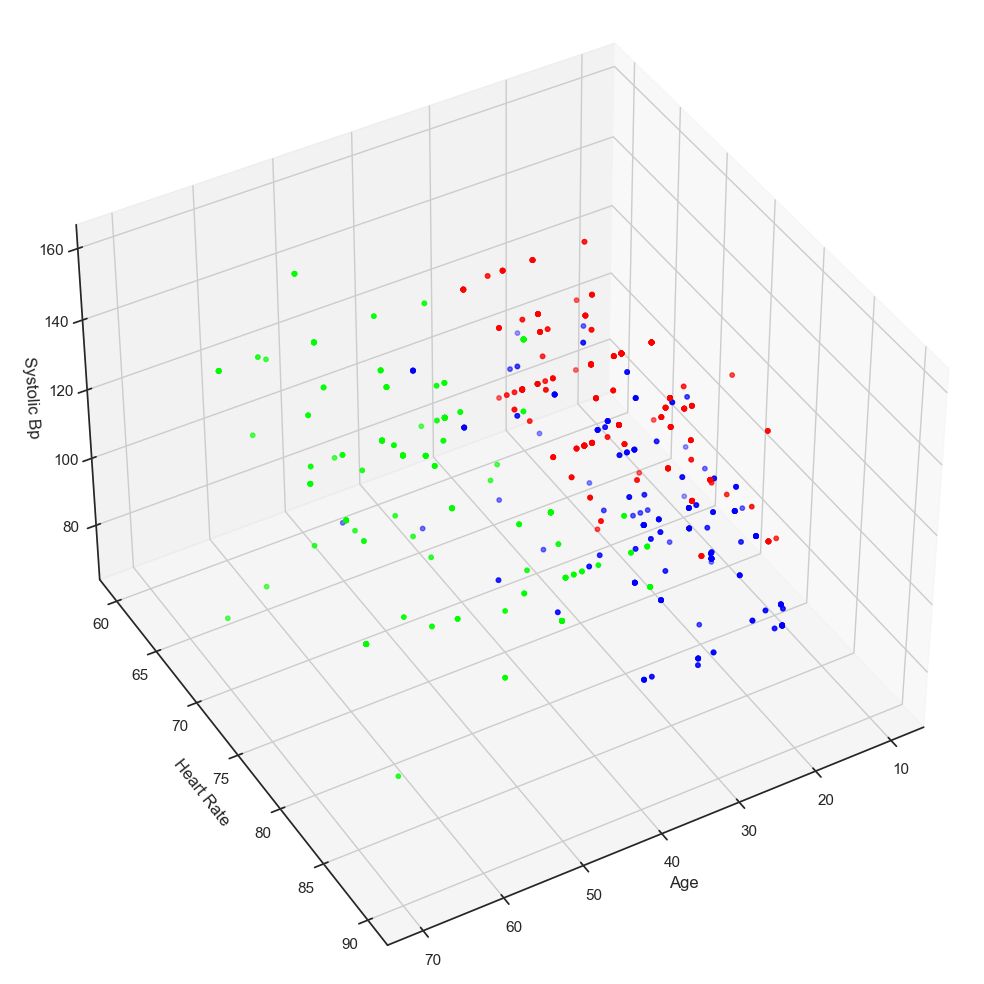

In [39]:
#as above but rotational view changed
fig3=plt.figure(figsize=(10,10))
ax= plt.axes(projection = '3d')
ax.set_xlabel('Age')
ax.set_ylabel('Heart Rate')
ax.set_zlabel('Systolic Bp')
plt.tight_layout()
ax.scatter(xs=syst_bp_df['Age'], ys = syst_bp_df['HeartRate'],zs=syst_bp_df['SystolicBP'], c=syst_bp_df['Cluster'],
 s = 10, cmap = 'brg')
ax.view_init(40, 60)

plt.savefig('clustering_rotate 3')

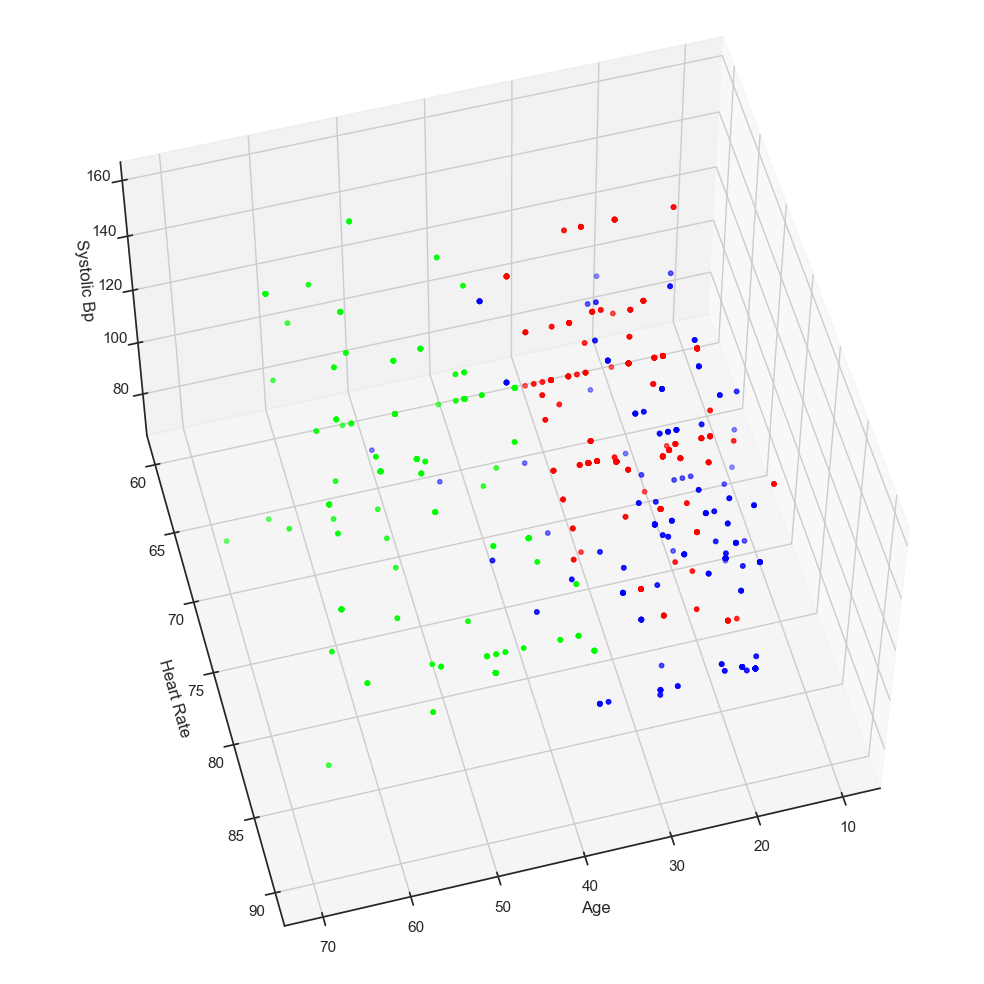

In [40]:
#as above but rotational view changed
fig4=plt.figure(figsize=(10,10))
ax= plt.axes(projection = '3d')
ax.set_xlabel('Age')
ax.set_ylabel('Heart Rate')
ax.set_zlabel('Systolic Bp')
plt.tight_layout()
ax.scatter(xs=syst_bp_df['Age'], ys = syst_bp_df['HeartRate'],zs=syst_bp_df['SystolicBP'], c=syst_bp_df['Cluster'],
 s = 10, cmap = 'brg')
ax.view_init(55, 75)

plt.savefig('clustering_rotate 4')

c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Matty\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

Text(0, 0.5, 'Inertia')

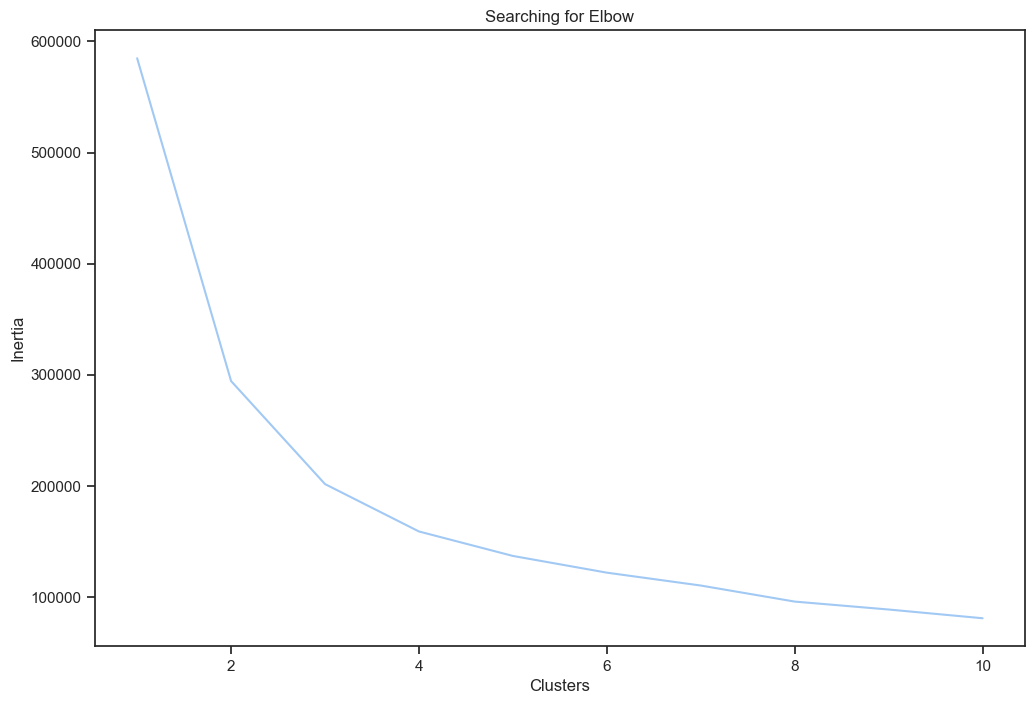

In [41]:
clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(syst_bp_df)
    clusters.append(km.inertia_)
#attempting differernt numbers of clusters
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
#plotting the interita of different clustes on a line grapgh to find the optimal number (3)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

### Correlation 

In [42]:
print(df['Age'].corr(df['SystolicBP']))
#calculating correlation of age and systolic BP

0.4160454479747331
